In [1]:
import numpy as np
from pylab import *

%matplotlib notebook

In [2]:
!ls data/SB40678/0407/


0407-debughdr-card1-lsb11-dp_b0.npy  0407-debughdr-card8-lsb11-dp.fits
0407-debughdr-card1-lsb11-dp.fits    0407-debughdr-card8-lsb11-dp.npy
0407-debughdr-card1-lsb11-dp.npy     0407-debughdr-card8-lsb11-ps_b0.npy
0407-debughdr-card1-lsb11-ps_b0.npy  0407-debughdr-card8-lsb11-ps.fits
0407-debughdr-card1-lsb11-ps.fits    0407-debughdr-card8-lsb11-ps.npy
0407-debughdr-card1-lsb11-ps.npy     header.bin
0407-debughdr-card8-lsb11-dp_b0.npy  header.txt


In [3]:
# load data from 0407 calibrator - debug headers were recorded from card 1, scaled to LSB=11, dual pol
# already filtered out only beamn 0
cal = np.load('data/SB40678/0407/0407-debughdr-card1-lsb11-dp_b0.npy')


<IPython.core.display.Javascript object>


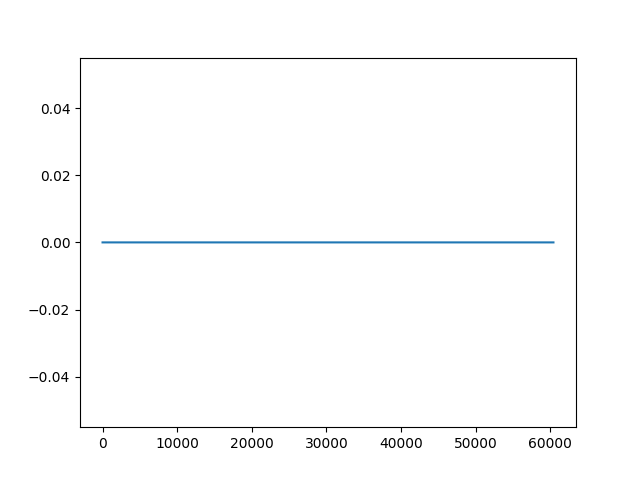

In [4]:
figure()
plot(cal['beam_number'])

In [5]:
cal.dtype

dtype([('frame_id', '<u8'), ('bat', '<u8'), ('beam_number', 'u1'), ('sample_number', 'u1'), ('channel_number', 'u1'), ('fpga_id', 'u1'), ('nprod', '<u2'), ('flags', 'u1'), ('zero1', 'u1'), ('version', '<u4'), ('zero3', '<u4'), ('data', '<i2', (1, 465, 2, 2))])

<IPython.core.display.Javascript object>


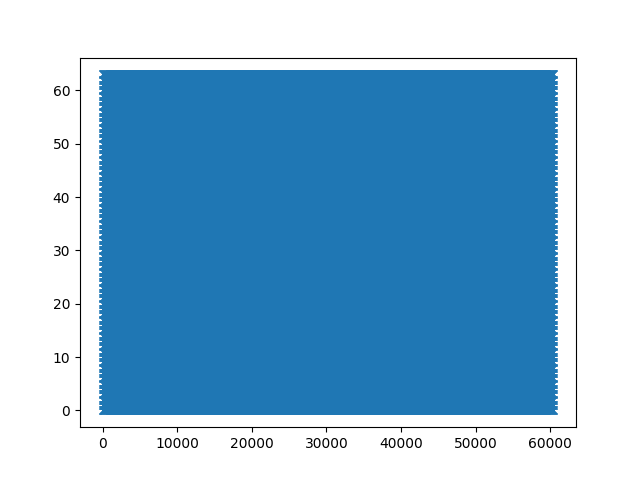

In [6]:
figure()
plot(cal['sample_number'],'x')

In [7]:

# calculate ordering of antenna data products
nant = 30
idx = 0
products = []
revproducts = {}
auto_products = []
cross_products = []
for a1 in range(1, nant+1):
    for a2 in range(a1, nant+1):
        print(f'{a1}-{a2}:{idx}')
        products.append((a1,a2))
        revproducts[(a1,a2)] = idx
        if a1 == a2:
            auto_products.append(idx)
        else:
            cross_products.append(idx)
            
        idx += 1


1-1:0
1-2:1
1-3:2
1-4:3
1-5:4
1-6:5
1-7:6
1-8:7
1-9:8
1-10:9
1-11:10
1-12:11
1-13:12
1-14:13
1-15:14
1-16:15
1-17:16
1-18:17
1-19:18
1-20:19
1-21:20
1-22:21
1-23:22
1-24:23
1-25:24
1-26:25
1-27:26
1-28:27
1-29:28
1-30:29
2-2:30
2-3:31
2-4:32
2-5:33
2-6:34
2-7:35
2-8:36
2-9:37
2-10:38
2-11:39
2-12:40
2-13:41
2-14:42
2-15:43
2-16:44
2-17:45
2-18:46
2-19:47
2-20:48
2-21:49
2-22:50
2-23:51
2-24:52
2-25:53
2-26:54
2-27:55
2-28:56
2-29:57
2-30:58
3-3:59
3-4:60
3-5:61
3-6:62
3-7:63
3-8:64
3-9:65
3-10:66
3-11:67
3-12:68
3-13:69
3-14:70
3-15:71
3-16:72
3-17:73
3-18:74
3-19:75
3-20:76
3-21:77
3-22:78
3-23:79
3-24:80
3-25:81
3-26:82
3-27:83
3-28:84
3-29:85
3-30:86
4-4:87
4-5:88
4-6:89
4-7:90
4-8:91
4-9:92
4-10:93
4-11:94
4-12:95
4-13:96
4-14:97
4-15:98
4-16:99
4-17:100
4-18:101
4-19:102
4-20:103
4-21:104
4-22:105
4-23:106
4-24:107
4-25:108
4-26:109
4-27:110
4-28:111
4-29:112
4-30:113
5-5:114
5-6:115
5-7:116
5-8:117
5-9:118
5-10:119
5-11:120
5-12:121
5-13:122
5-14:123
5-15:124
5-16:125
5-17:126
5-

In [8]:
# Now we spend some time reshapign the data to somethign more managable
print(cal['data'].shape) # (time  blocks x channels, integrations, baselines, polarisations)

# cinput data is int16. We'll create a new array that's complex valued.
d = np.zeros(cal['data'].shape[:-1], dtype=np.complex)

# set real and imagainary parts appropriately
d.real = cal['data'][...,0]
d.imag = cal['data'][...,1]

(60416, 1, 465, 2, 2)


In [9]:
#The first dimension is a list of

nblocks = d.shape[0]//(4*64)
print(nblocks)

236


In [10]:
d.shape

(60416, 1, 465, 2)

In [11]:
dcross = d[:nblocks*64*4, ...].reshape(nblocks, 4, 64, 465, 2)

In [12]:
dcross.shape # (time blocks, chanenels, samples, baselines, polarisations)

(236, 4, 64, 465, 2)

In [13]:
dcross = np.transpose(dcross, [0,2, 1, 3,4])

In [14]:
dcross.shape # (time block,s samples, channels, baeslines, polariasations)

(236, 64, 4, 465, 2)

In [15]:
dcross = dcross.reshape(dcross.shape[0]*dcross.shape[1], 4, 465, 2)

In [16]:
dcross.shape # (samples, channels, baselines, polarisations)

(15104, 4, 465, 2)

In [17]:
# take the mean over time
tmean = dcross[:,:,cross_products,:].mean(axis=0)
tmean = np.transpose(tmean, axes=[1,0,2]) 

In [18]:
tmean.shape # baselines, channels, polarisations

(435, 4, 2)

In [19]:
allbl = tmean.reshape(-1,2)
allbl.shape # (baselines*channels, polarisations)

(1740, 2)

<IPython.core.display.Javascript object>


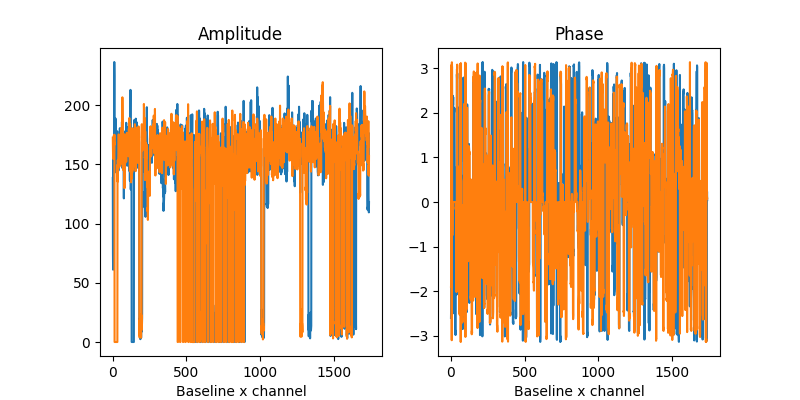

In [20]:
# expect this to group into blocks of 4 channels
fig, ax = subplots(1,2, sharex=True)
ax[0].plot(np.abs(allbl))
ax[1].plot(np.angle(allbl))
ax[0].set_xlabel('Baseline x channel')
ax[1].set_xlabel('Baseline x channel')
ax[0].set_title('Amplitude')
ax[1].set_title('Phase')
fig.set_size_inches([8,4])

<IPython.core.display.Javascript object>


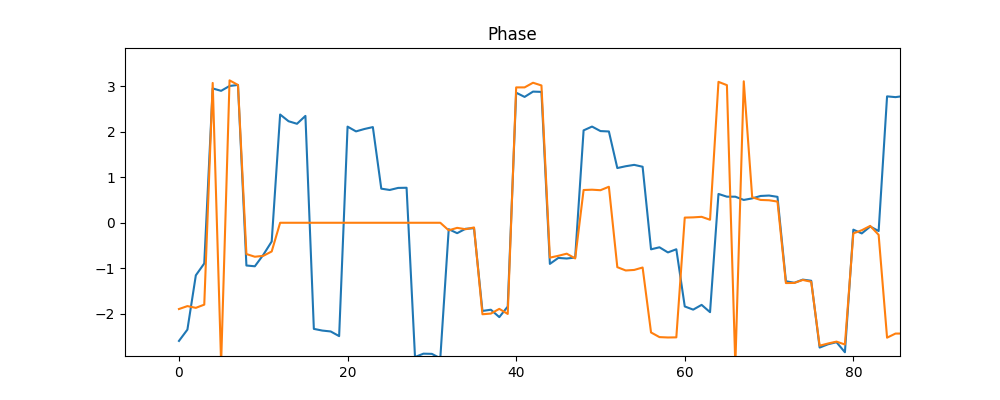

(0.0, 300.0)

In [21]:
fig= figure()
plot(np.angle(allbl))
fig.set_size_inches([10,4])
title('Phase')
xlim(0,300)

<IPython.core.display.Javascript object>


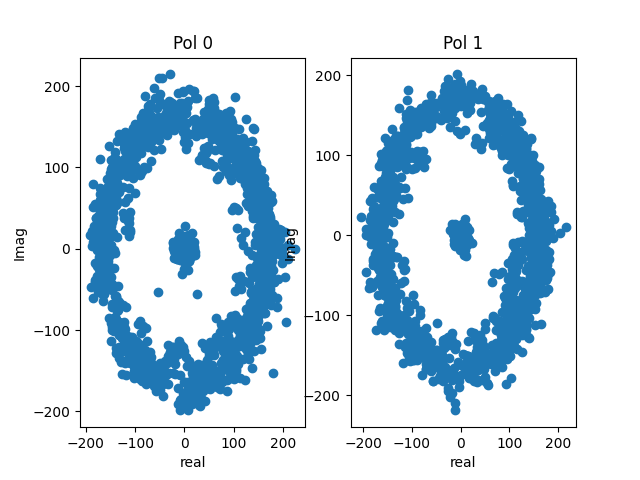

Text(0.5, 1.0, 'Pol 1')

In [22]:
fig, ax = subplots(1,2)
ax[0].scatter(allbl.real[:, 0], allbl.imag[:, 0])
ax[1].scatter(allbl.real[:, 1], allbl.imag[:, 1])

ax[0].set_xlabel('real')
ax[0].set_ylabel('Imag')

ax[1].set_xlabel('real')
ax[1].set_ylabel('Imag')

ax[0].set_title('Pol 0')
ax[1].set_title('Pol 1')

<IPython.core.display.Javascript object>


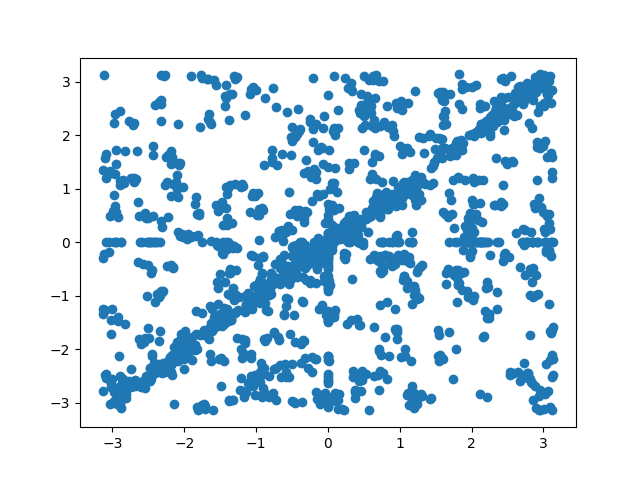

In [23]:
figure()
scatter(np.angle(allbl[:, 0]), np.angle(allbl[:, 1]))

<IPython.core.display.Javascript object>


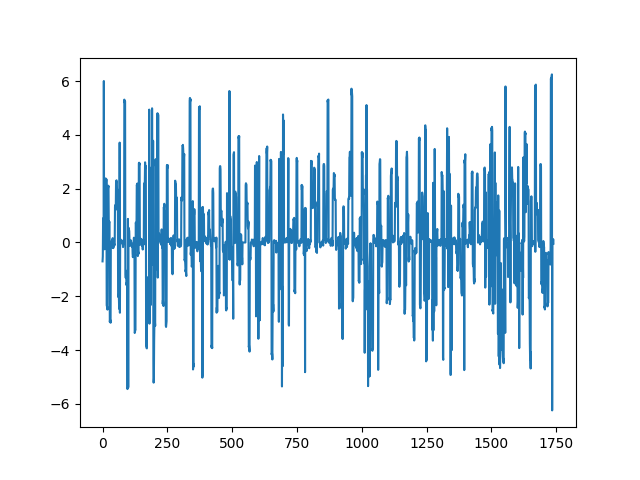

In [24]:
figure()
plot(np.angle(allbl[:,0])-np.angle(allbl[:,1]))